# Executive Summary

**Goal**

The goal of this project is try and classify a sample from a cancerous cell as benign or malignant based on data from the "Breast Cancer Wisconsin (Diagnostic) Data Set." The dataset looks at a 31 different measurements of the cell nucleii which are used to generate that prediction.

**Data Cleaning and Manipulation**

The data is clean, although there is significant positive skew (a long tail to the right) which I try to compensate for by running the data through a standard scaler using mean and standard deviation to alleviate some of that skew. 

**Model Selection**

In this project I looked at the following three different models to act as classifiers: XGBoost Classifier, Light GBM Classifier, and Support Vector Classifier. I used F1 Score and a confusion matrix to compare the models.

**Outcome**

Ultimately, the Support Vector Classifier was the best performer on the validation data in the tuning process, though all three got identical F1 scores of 0.974 on the unseen test data. Classifing nucleii as benign or malignant based on morphological features is clearly possible using a classifier. This could be used to build a tool to assist doctors with diagnoses or possibly guide future research on important morphological and biomechanical features for diagnostics or treatment.

# Problem Background

The "Breast Cancer Wisconsin (Diagnostic) Data Set" consists of measurements made on the cell nucleii found in a sample taken from a fine needle aspiration biopsy. The measurements describe various dimensions of the cell nucleii such as average radius, standard error of radius, concavity, etc. for a total of 31 columns, as well as whether or not the cell was determined to be a part of a malignant or benign tumor. It's important to be able to differentiate between benign and malignant tumors as the treatment moving forward varies in the effectiveness as well as in harmful side effects.

For a malignant tumor, options include, but aren't limited to, chemotherapy, a massectomy, and/or radiation treatment. These treatments are typically hard on the patient's body and can have long term health and quality of life implications for the patient, so it's important to be sure that the patient is suffering from metastasized tumor rather than a benign one so as not to cause unnecessary harm. Alternatively, if a malignant tumor is mistaken as benign, then the cancer is given an opportunity to spread and metastasize which can lead to the cancer becoming untreatable and ultimately kill the patient.

An [interesting paper here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4591936/) explores the mechanics of the change for nucleii cancerous cells are comprised of. Of greatest relevance to this project is the section labeled "Implications of altered nuclear envelop composition in cancer."

The obstacles a cell needs to overcome in  order to become cancerous are clearly laid out in the "Hallmarks of Cancer" diagram below.

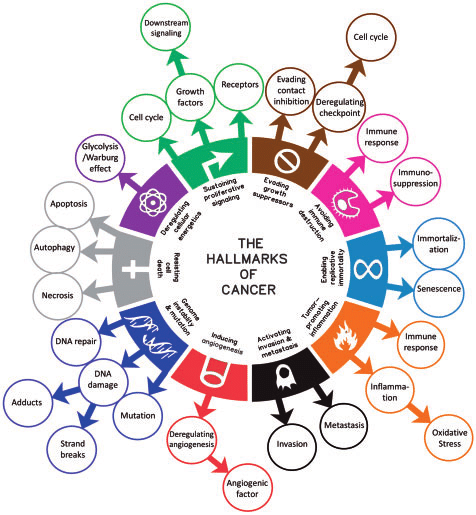

Our focus will be on "Activating Invasion and Metastasis" as it most directly relates to the size, shape, and texture of a nucleus. I am framing everything with respect to a focus on a cancer cell metastisizing as there are greater roadblocks for that happening than for a tumor to be benign. Also, metastatic cancer is more dangerous to a patient, so I am more interested in capturing those instances.  

Traditionally, the focus of research has been on DNA in attempting to recognize potentially cancerous cells among normal ones, but as technology has been developed to visually observe cells and science has progressed, there is a growing emphasis on looking at biomechanical markers to identify cancerous cells.

In order for a cancerous cell to spread to other parts of the body, it must be able to move through incredibly tight spaces such as those found in capilaries and between other spaces. Much in the same way an [octopus is limited by its rigid beak](https://www.youtube.com/watch?v=E3N0i_KM8cI) to squeeze through a gap, a cell is limited my its rigid nucleus. With that in mind, a metastatic cell would benefit from having a deformable nucleus to further decrease the minimum gap size it could squeeze through.

While there currently isn't a way to directly measure the deformability of a cell's nucleus,it can be reasoned that it's deformability would need to increase to allow the potentially metastatic cell to be successfully invasive. Other components of the cell, including the cytoskeleton, cell membrane, etc., are either already flexible or easily broken down and reconstructed whereas neither of these facts are true of a typical nucleus. 

As a bit of an aside (and possible something to explore in another project), another large organelle is the mitochondria. In [this article](https://www.nature.com/articles/onc2012494) it is described that in metastatic breast cancer, cells with an imbalance of Drp1 and Mfn (favoring an excess of Drp1) had mitochondria that underwent a greater amount of fission than fusion. This made the mitochondria smaller and more mobile, allowing them to be moved to areas of higher energy demand. I imagine it would also allow the cell as a whole to be less restricted in moving through small spaces. It is noted in the article that it is currently unknown whether the imbalance contributes to metastasis. [Another article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6932960/) explores the potential link between mitochondrial abnormalities and metatastasis more in-depth.

The nucleii found in normal cells are smooth, rigid, and ellipsod, while cancerous cells can be any combination of irregular, flexible, and/or oblong in shape. Another interesting occurence with mobile cells is that their nucleii will often undergo tearing, sometimes repeatedly. Sometimes, the nuclear envelope will reform with other organelles, proteins, or other materials not normally found in the nucleus. The tearing also exposes the chromatin to further disruption and mutation. 

As I explore the data a couple of things I'll keep in mind are the following:
- Nucleii need to be small and flexible enough to be able to squeeze through interstitial spaces or into and out of blood vessels
- In the process of squeezing through gaps nucleii can be damaged resulting in an irregular shape

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# set seed for sklearn, without this even if the inputs are identical the sklearn models will have different outputs
np.random.seed(0)

In [ ]:
df = pd.read_csv(r'/kaggle/input/breast-cancer-wisconsin-data/data.csv')
df.drop('Unnamed: 32', axis=1, inplace=True)
df.describe()

In [ ]:
df.set_index('id', inplace=True)
print(df.columns)

**At A Glance**

So looking through this dataset, it is already incredibly clean. No NA values so no need to do any imputing or row dropping, and no categorical data that needs to be encoded (except the diagnosis), just 30 columns of measurements of tumors, and the diagnosis. 


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Diagnosis_labels'] = encoder.fit_transform(df['diagnosis'])
df.drop('diagnosis', axis=1, inplace = True)
df = df.sample(frac=1)

o_df = df.copy() # stands for original df, basic cleaning, no distribution correction

In [ ]:
decode_dict = {0: 'Benign', 1:'Malignant'}

In [ ]:
df['Diagnosis_labels'].value_counts()

The data is well balanced, so no need to compensate for that with certain models, unless later I find that my models aren't able to perform well in both precision and recall (captured by the f1 score I am using to judge the models on). 

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff
columns_chunks = [df.columns[:6], df.columns[6:12], df.columns[12:18], df.columns[18:24], df.columns[24:]]
for columns in columns_chunks:
    data = [df[column] for column in columns]
    group_labels = [column for column in columns]
    fig = ff.create_distplot(data, group_labels)
    #fig.show()

In [ ]:
for i in df.columns:
    if i != 'Diagnosis_labels':
        fig = px.histogram(df, x=i, color='Diagnosis_labels')
        fig.show()

A look at the colored histograms of the columns in the dataset shows that there are not clean differences in the distributions of the individual features for malignant and benign tumor cells. I would be interested to know how these measurements stack up against a normal healthy cell for some comparison. 

In [ ]:
def shift_list(_list):
    shifted_list = [None]*len(_list)
    for i in range(len(_list)):
        shifted_list[i] = _list[i-1]
    return shifted_list

In [ ]:
#test shift_list function
class my_Tests:
    def __init__(self):
        self.test_1_expected = [6, 1, 2, 3, 4, 5]
        self.test_1_input = [1, 2, 3, 4, 5, 6]
        
        self.test_2_expected = [False, False, True, False, False]
        self.test_2_input = [False, True, False, False, False]
    def test_1(self):
        result = shift_list(self.test_1_input)
        if result == self.test_1_expected:
            print('Passed') 
        else:
            print('Expected', self.test_1_expected, 'but got', result)
    def test_2(self):
        result = shift_list(self.test_2_input)
        if  result == self.test_2_expected:
            print('Passed') 
        else: 
            print('Expected', self.test_2_expected, 'but got', result)

T = my_Tests()
T.test_1()
T.test_2()

In [ ]:
import plotly.graph_objects as go
def multi_hist(_df):
    columns = list(_df.columns)
    columns.pop(columns.index('Diagnosis_labels'))
    active_list = [True]*len(columns) 
    my_buttons = [dict(
        args=[{'visible':active_list}],
        label='All',
        method='update'
        )]
    active_list = [True]+([False]*(len(columns)-1))
    fig = go.Figure()
    for i in columns:
        fig.add_trace(go.Histogram(x=_df[i], name=i))
        my_buttons.append(
            dict(args=[{'visible':active_list}],
                 label=i,
                 method='update'
        ))
        active_list = shift_list(active_list)

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=my_buttons,
                direction='down',
                pad={'r':.1, 't':10},
                showactive=True,
                x=0.04,
                xanchor='left',
                y=1.2,
                yanchor='top'
            )])

    fig.update_layout(
        annotations=[
            dict(text='Column', x=0, xref='paper', y=1.15, yref='paper', align='left', showarrow=False)
        ])
    fig.show()

# Handling Skewness


In [ ]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from math import log
#boxcox = PowerTransformer(method='box-cox')

skew_before = {}
columns = list(o_df.columns)
columns.pop(columns.index('Diagnosis_labels'))
boxcox_columns = []
for col in columns:
    skew_before[col] = df[col].skew()

t_df = pd.DataFrame()
skew_after = {}
for col in columns:
    if skew_before[col] >.5 and df[col].min() >0:
        t_df[col] = boxcox(df[col])[0]
        skew_after[col] = t_df[col].skew()
        boxcox_columns.append(col)
        print(col, 'Skew Before', skew_before[col], 'and Skew After', skew_after[col])
    else:
        t_df[col] = list(df[col])
        
#Fix columns that behaved poorly with box-cox and re-add daignosis labels
t_df['fractal_dimension_mean'] = list(o_df['fractal_dimension_mean'])
t_df['fractal_dimension_worst'] = list(o_df['fractal_dimension_worst'])
boxcox_columns.pop(boxcox_columns.index('fractal_dimension_mean'))
boxcox_columns.pop(boxcox_columns.index('fractal_dimension_worst'))
t_df['Diagnosis_labels'] = list(o_df['Diagnosis_labels'])
t_df.head()

# Mean and Ranged to -1 to 1, Standard Scaler

In [ ]:
def mean_center(series):
    mean = series.mean()
    mean_centered_series = series.apply(lambda x: x-mean)
    return mean_centered_series
    
def rescale(series): 
    lowest = series.min()
    highest = series.max()
    scaler = lowest if abs(lowest)> highest else highest
    rescaled_series = series.apply(lambda x: x/scaler)
    return rescaled_series

rs_df = pd.DataFrame()
for col in columns:
    rs_df[col] = rescale(mean_center(o_df[col]))
rs_df['Diagnosis_labels'] = list(o_df['Diagnosis_labels'])
rs_df.head()

In [ ]:
o_df.var()

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_df= ss.fit_transform(o_df[columns])
ss_df = pd.DataFrame(ss_df, columns=columns)
ss_df['Diagnosis_labels'] = list(o_df['Diagnosis_labels']) 
ss_df.head()

In [ ]:
multi_hist(o_df)
multi_hist(t_df)
multi_hist(rs_df)
multi_hist(ss_df)

# Set DF for model training

In [ ]:
temp_df = ss_df.copy()
temp_df.describe()

In [ ]:
df.describe()

In going through all the distributions, it is clear that there are a large number of outliers that need to be dealt with.

# Prepare Train Valid Test Data

**Split data for training/validation.**


In [ ]:
from sklearn.model_selection import train_test_split

y = temp_df['Diagnosis_labels'].copy()
X  = temp_df.copy()
X.drop('Diagnosis_labels', axis=1, inplace = True)
X, test_X, y, test_y = train_test_split(X, y, train_size=.8, test_size=.2, random_state=0)
train_X, valid_X, train_y, valid_y = train_test_split(X, y, train_size = .7, test_size = .3, random_state=0)

# Naive Score

To assess how effective this is, let's assume a totally naive model would always guess the most common value, which in this case is benign. 



In [ ]:
from random import randint, seed
from sklearn.metrics import f1_score
seed(0)
all_malignant = pd.Series([1] * X.shape[0])
all_benign = pd.Series([0] * X.shape[0])
random_guess = [randint(0, 1) for i in range(X.shape[0])]
naive_f1_score = f1_score(all_benign, y, average='binary')
print('Naive f1 score for always guessing "Benign" is', naive_f1_score)
naive_f1_score = f1_score(all_malignant, y, average='binary')
print('Naive f1 score for always guessing "Malignant" is', naive_f1_score)
naive_f1_score = f1_score(random_guess, y, average='binary')
print('Naive f1 score for randomly guessing', naive_f1_score)

baseline_score = f1_score(all_malignant, y, average='binary')

In [ ]:
swapped_y = y.apply(lambda x: 1 if x==0 else 0)
print(f1_score([1]*X.shape[0], swapped_y))

In [ ]:
malignant_count = valid_y[valid_y == 1].shape[0]
benign_count = valid_y[valid_y == 0].shape[0]
print('Ratio of malignant to total:', malignant_count/(malignant_count+benign_count))
print('Ratio of benign to total:', benign_count/(malignant_count+benign_count))

As a naive baseline, always guessing benign would result in an f1 score of .765. Any model I train needs to beat this score to be considered an improvement.

# Cross Validation

In [ ]:
#Cross validation
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
def get_cross_val_score(_model, folds=5):
    pipeline = Pipeline(steps=[('model', _model)])
    scores = cross_val_score(pipeline, X, y, cv=folds, scoring = 'f1')
    return (scores.mean())
get_cross_val_score(XGBClassifier(n_estimators = 1000, learning_rate = .05, n_jobs=4))

With just a quick check, a basic XGBoost Classifier is performing far better than the Naives score, which is promising.

In [ ]:
from sklearn.model_selection import GridSearchCV
#Use Grid when there is a low combination of parameters, and randomized when it starts to be too costly

This is a small dataset and I'm not going to dive too deep into parameter tuning, so GridSearch is fine for me at the moment. 

# Light GBM Classifier

Tuning Docs:

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

Start with selecting a booster, then tune n_estimators, num_leaves, min_data_in_leaf, and max_depth. Its few enough parameters that they can all be tuned simulataneously.

Parameter Docs:

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
# Light GBM Classifier
from lightgbm import LGBMClassifier
from statistics import mean

lgb = LGBMClassifier()
lgb_params = {'booster':['gbdt', 'dart']}

lgb_grid_search = GridSearchCV(lgb, lgb_params, scoring='f1', cv=5, refit=True)
lgb_grid_search.fit(train_X, train_y)
print('Best Score:', lgb_grid_search.best_score_)
print('Best Parameters:', lgb_grid_search.best_params_)
print('Train Score:', lgb_grid_search.score(train_X, train_y))
print('Valid Score:', lgb_grid_search.score(valid_X, valid_y))

In [ ]:
lgb = LGBMClassifier()
lgb_params = {'n_estimators':[50, 100, 300, 500, 1000],
          'num_leaves':[i for i in range(50, 150, 10)],
          'min_data_in_leaf':[100, 500, 1000, 1500, 2000],
          'max_depth':[i for i in range(3, 8)]}

lgb_grid_search = GridSearchCV(lgb, lgb_params, scoring='f1', cv=5, refit=True)
lgb_grid_search.fit(train_X, train_y)
print('Best Score:', lgb_grid_search.best_score_)
print('Best Parameters:', lgb_grid_search.best_params_)
print('Train Score:', lgb_grid_search.score(train_X, train_y))
print('Valid Score:', lgb_grid_search.score(valid_X, valid_y))

In [ ]:
lgb = LGBMClassifier()
lgb_params = {'n_estimators':[i for i in range(220, 290, 5)],
          'num_leaves':[i for i in range(50, 100, 5)],
          'min_data_in_leaf':[i for i in range(50, 70, 5)],
          'max_depth':[3, 4]}

lgb_grid_search = GridSearchCV(lgb, lgb_params, scoring='f1', cv=5, refit=True)
lgb_grid_search.fit(train_X, train_y)
print('Best Score:', lgb_grid_search.best_score_)
print('Best Parameters:', lgb_grid_search.best_params_)
print('Train Score:', lgb_grid_search.score(train_X, train_y))
print('Valid Score:', lgb_grid_search.score(valid_X, valid_y))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lgb_params = {'n_estimators':275,
          'num_leaves':5,
          'min_data_in_leaf':50,
          'max_depth':3}

lgb_params = {'n_estimators':250,
          'num_leaves':50,
          'min_data_in_leaf':60,
          'max_depth':3}

lgb = LGBMClassifier(**lgb_params)
lgb.fit(X, y)
lgb_predictions = lgb.predict(test_X)
print('F1_score', f1_score(test_y, lgb_predictions))
lgb_cf_matrix = confusion_matrix(test_y, lgb_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in lgb_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in lgb_cf_matrix.flatten()/np.sum(lgb_cf_matrix)]
labels = [f'{_1}\n{_2}\n{_3}' for _1, _2, _3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lgb_cf_matrix, annot=labels, fmt='')


I would much rather have more False Positives than False Negatives as the worst case scenario for a False Positive is harmful treatment, whereas the worst case scenario for a False Negative is death by metastatic cancer. By that standard this model did pretty good, but the False Negatives aren't great. Let's see if we can do better.

In [ ]:
lgb_features_importances = pd.DataFrame()
lgb_features_importances['Columns'] = train_X.columns
lgb_features_importances['Feature_Importances'] = lgb.booster_.feature_importance(importance_type='gain')
lgb_features_importances.sort_values(['Feature_Importances'], inplace=True)
fig_lgb_feature = px.bar(lgb_features_importances, x = 'Columns', y='Feature_Importances') 
fig_lgb_feature.show()

This is interesting, as there are features that make sense to use for classifying the nucleii as intuitively it aligns with what I was able to learn about how the nucleii change to squeeze through tight gaps and get damaged in transit, but I am surprised that radius and compactness appear to have played a minimal role in the model building.

# XGBClassifier
For how to tune the parameters of XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

TLDR: Tune in this order
1. n_estimators, learning_rate, max_depth 
2. min_child_weight
3. gamma
4. subsample,colsample_bytree

For each one, start with a broad spread, then a narrower spread centered on best performers
For the sake of space, I'll do this in two seperate cells for the first round only

In [ ]:
#Optimize XGBoost
xgb_params = {'max_depth':[i for i in range(3,11, 2)], 
              'n_estimators':[100, 300, 500, 1000, 5000, 10000], 
              'learning_rate':[.1], 
              'n_jobs':[4],
              }
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))

In [ ]:
#Optimize XGBoost
xgb_params = {'max_depth':[5], 
              'n_estimators':[i for i in range(150, 250, 10)], 
              'learning_rate':[.1], 
              'n_jobs':[4], 
              }
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))

This is a great score, so now I will set the current parameters as fixed and start tuning some of the more nuanced parameters

In [ ]:
xgb_params = {'max_depth':[5], 
              'n_estimators':[190], 
              'learning_rate':[.1], 
              'n_jobs':[4], 
              'min_child_weight':[i for i in range(1, 6)]}
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))

In [ ]:
xgb_params = {'max_depth':[5], 
              'n_estimators':[190], 
              'learning_rate':[.1], 
              'n_jobs':[4], 
              'min_child_weight':[1],
              'gamma':[i/10.0 for i in range(5)]}
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))

In [ ]:
xgb_params = {'max_depth':[5], 
              'n_estimators':[190], 
              'learning_rate':[.1], 
              'n_jobs':[4], 
              'min_child_weight':[1],
              'gamma':[0],
              'subsample':[i/10.0 for i in range(6, 10)],
              'colsample_bytree':[i/10.0 for i in range(6, 10)]}
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))

In [ ]:
xgb_params = {'max_depth':[5], 
              'n_estimators':[190], 
              'learning_rate':[.1], 
              'n_jobs':[4], 
              'min_child_weight':[1],
              'gamma':[0],
              'subsample':[.7],
              'colsample_bytree':[.8],
              'reg_alpha':[0, 1e-5, 1e-2, .1]}
xgb = XGBClassifier()
xgb_rand_search  = GridSearchCV(xgb, xgb_params, scoring='f1', cv=5, refit=True)
xgb_rand_search.fit(train_X, train_y)
print('Best Score:', xgb_rand_search.best_score_)
print('Best Parameters:', xgb_rand_search.best_params_)
print('Train Score:', xgb_rand_search.score(train_X, train_y))
print('Valid Score:', xgb_rand_search.score(valid_X, valid_y))

Final parameter values for the XGBClassifier are as below


In [ ]:
xgb_params = {'max_depth':5, 
              'n_estimators':190, 
              'learning_rate':.1, 
              'n_jobs':4, 
              'min_child_weight':1,
              'gamma':0,
              'subsample':.7,
              'colsample_bytree':.8,
              'reg_alpha':0}
my_xgb = XGBClassifier(**xgb_params)
my_xgb.fit(X, y ,verbose=False)
xgb_predictions = my_xgb.predict(test_X)
print('F1 score', f1_score(test_y, xgb_predictions))
xgb_cf_matrix = confusion_matrix(test_y, xgb_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in xgb_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in xgb_cf_matrix.flatten()/np.sum(xgb_cf_matrix)]
labels = [f'{_1}\n{_2}\n{_3}' for _1, _2, _3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(xgb_cf_matrix, annot=labels, fmt='')

A solid score, but I would argue False Negatives are more dangerous to the patient than False Positives, so lets keep going.

In [ ]:
xgb_features_importances = pd.DataFrame(my_xgb.get_booster().get_score(importance_type='gain').items(), columns = ['Columns', 'Feature_Importances'])
xgb_features_importances.sort_values(['Feature_Importances'], inplace=True)
fig_xgb_feature = px.bar(xgb_features_importances, x = 'Columns', y='Feature_Importances') 
fig_xgb_feature.show()

XGBoost Classifier tends to agree with LightGBM in terms of what features are the most important, with the exception that LightGB made greater use of texture than XGBoost. Could an effective classifier be built with only 5-10 of the most important features? If such a classifier were to be deployed in an environment where measurements were to be taken from a sample, either by hand or through automation, it would be far less time consuming and require less resources collect of only a handful of features rather than 31.

# Support Vector Classifier

[Tuning docs](https://scikit-learn.org/stable/modules/grid_search.html)

In [ ]:
# SVC Model 

#TODO change all the ms to cs
from sklearn.svm import SVC
def my_svc(_train_X, _train_y, _valid_X, _valid_y, _kernel, _degree=3):
    svc_model = SVC(kernel=_kernel, degree=_degree)
    svc_model.fit(_train_X, _train_y)
    svc_predictions  = svc_model.predict(_valid_X)
    svc_score = f1_score(svc_predictions, _valid_y)
    print('F1 score for SVC model is', svc_score)

In [ ]:
#Optimize SVC
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    print(kernel)
    my_svc(train_X, train_y, valid_X, valid_y, kernel)

#Linear looks the best, but it's worth exploring polynomial to make sure that it isn't equally viable

for i in range(2, 5):
    print('For "poly" kernelm of degree',i)
    my_svc(train_X, train_y, valid_X, valid_y, 'poly', _degree=i)

#Linear still seems like the best option.

svc_params = {'kernel':['linear', 'rbf'],'C':[0.01,0.1,1,0.001],'gamma':[0.1,0.01,0.2,0.4]}
svc = SVC(probability = True)
svc_grid_search = GridSearchCV(svc, svc_params, scoring='f1',cv = 5,refit = True)

svc_grid_search.fit(train_X, train_y)
print()
print("Best Score ==> ", svc_grid_search.best_score_)
print("Tuned Paramerers ==> ",svc_grid_search.best_params_)
print("Accuracy on Train set ==> ", svc_grid_search.score(train_X,train_y))
print("Accuracy on Test set ==> ", svc_grid_search.score(valid_X, valid_y))



In [ ]:
svc_params = {'kernel':'linear',
              'C':0.1,
              'gamma':0.1}
svc = SVC(**svc_params)
svc.fit(X, y)
svc_predictions = svc.predict(test_X)
print('F1 score', f1_score(test_y, svc_predictions))
svc_cf_matrix = confusion_matrix(test_y, svc_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in svc_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in svc_cf_matrix.flatten()/np.sum(svc_cf_matrix)]
labels = [f'{_1}\n{_2}\n{_3}' for _1, _2, _3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(svc_cf_matrix, annot=labels, fmt='')

Another solid score. Unfortunately identical to XGBoost in the case of False Negatives. However, it did have the best "best score" and accuracy on the validation set during optimization, so I would probably select the SVC model to use moving forward.

In [ ]:
svc_features_importances = pd.DataFrame()
svc_features_importances['Feature_Importances'] = svc.coef_[0]
svc_features_importances['Columns'] = train_X.columns
svc_features_importances.sort_values(['Feature_Importances'], inplace=True)
fig_svc_feature = px.bar(svc_features_importances, x = 'Columns', y='Feature_Importances') 
fig_svc_feature.show()

With SVM Classifier, the coeficients refer to how much a feature points towards each of the classes, so absolute value is important for denoting importance. It's interesting spread to see a far more evenly distributed spread of weights compared to the XGB and LightGB Classifiers. The only features I would say are minimally important here are the symmetry mean and se, concave points, concavity se, compactness worst, and smoothness mean.

# Wrap-Up and Next Steps

All 3 models ended up with f1 scores of 0.974 on the unseen test data with two False Negatives each. Overall, I'm happy with the results and it's clear that the morphological features have immense promise is differentiating malignant tumor cells from benign ones. For further research and exploration I would select the SVM Classifier as it scored better during the optimization process suggesting high variance (some overfitting) with the training data for the other two models. That being said, I would like to show this model more new data from as diverse a population as possible just to keep exploring what features are the most valuable, which could hint at future treatment options. 

I would also need to explore further into how this model is classifying based on the various features so that I could help a non-data science practitioner to be able to trust it. Most healthcare professionals need at least some semblance of "why the model does what it does," and would never blindly trust a blackbox, especially as it pertains to people's health. 

If I were to explore further testing to create more data to train models off of, I would delve into other factors from the hallmarks of cancer and how they relate to the nucleus, or even other organelles altogether. For example, It would be fascinating if it were possible to detect the presence of debris or organelles not typically found in the nucleus, in the nucleus as it might indicate the nuclear envelope has been torn and reformed. Additionally, I mentioned in the beginning how large mitochondria are and there potential role in metastasis, so combining mitochondrial and nuclear morphology could yield even better results.

 
# Why This All Matters and Future Direction

The need for oncologists is [increasing](https://www.ncbi.nlm.nih.gov/books/NBK215252/) as the number of people who need cancer treatment are increasing. To compound the issue, we are experiencing a cultural shift where surveyed doctors entering the field are placing greater importance on work-life balance. Similar stories exist in all branches of medicine. The medical field is demanding with the knowledge base growing exponentially, patient load increasing, life extension demanding further care, and a horrifying lack of trust in educated proffesionals due to the widespread dissemination of misinformation. On the current trajectory I can only see this situation getting worse. However, we can find a potential way to alleviate some of the burden on the healthcare system in another industry altogether. 

Let's take a look at PayPal. In 2000 PayPal was hemorrhaging money due to credit card fraud. So, to combat this they tried to create an algorithm that would detect fraud and stop it. Due to the rigid nature of their algorithms, and the adaptive nature of their human adversaries, the humans would overcome the algorithm faster than PayPal could ever keep up with. They discovered that using humans to sort through transactions was incredibly effective, but there were simply too many transactions to go throught quickly.

The solution was a hybrid approach. The algorithm would sort through the "obvious" transactions, and pass off anything suspicious or unknown to a small human team, while clearing the bulk of transactions that were non-fraudulent. This fix ultimately led to PayPal turning a profit, was used by the FBI to detect fraud, and layed the groundwork for Palantir. 

Back to our overworked doctors. If a similar approach were to be taken with the medical field, it could free up doctors to focus on problems that are more nuanced and require complex multidimensional problem solving. Picture this: a sample is collected from the patient and measurements are fed through an algorithm. Outcomes the algorithm is confident in allow the doctor to move straight into the treatment phase, while the low confidence guesses are given to the doctor for further investigation. If these systems were to be combined with automation in data collection of the patient, more patients could be diagnosed and treated with far less burden on staff. In summary technology would allow a team to do more with less and leverage their most "human" aspects of problem solving and care.

That leads to another exploration of this data. Instead of simply attempting to classify the data, I would at some point like to explore regression on the data to try and assign a confidence value to how likely a sample is to being benign or malignant. 



If you are all the way down here, thank you for taking the time to read through this notebook. Feel free to leave any questions or point out any errors I made in the comments.

Cheers!

Jeb